# OCNG/ATMO 651 Final Project: Linear Inverse Model of Tropical Sea Surface Temperatures

## Dataset
NCEP/NCAR Reanalysis monthly-mean SST from 1948-01 to 2017-09. The dataset are divided into two parts: the training set and the test set. The training set contains 1948-01 to 1999-12, and the test set contains 2000-01 to 2017-09.

## Steps

1. Smooth SST anomalies (SSTAs) using a 3-month running mean and then perform an EOF analysis on the smoothed SSTAs;
2. Reconstruct and truncate SSTAs using leading EOFs and the corresponding principal component time series as, $T(t)=\sum _{i=1}^M P_(t) E_i$, where $E_i$ is the $i$-th EOF, $P_i(t)$ is the $i$-th principal component, $M$ is the number of EOFs used to represent $T(t)$. Typically, $M$ is less than 10 and can be determined by the explained variance, say 90%, by the first $M$ EOFs;
3. Compute covariance and lag-covariance matrix in EOF space, $ \check{C} = \overline{P(t)P'(t)}$, $\check{C}_{\Delta t} = \overline{P(t+\Delta t)P'(t)} $ (overline stands for time average), where $\check{C}$ and $\check{C}_{\Delta t}$ are the covariance and lag-covariance matrix in EOF space, $P(t)_{M\times 1}$ is a state vector of $P_i(t)$ and $P'(t)$ is its transpose, i.e., $P'(t) = [P_1(t), P_2(t), …, P_M(t)]_{1\times M}$;
4. Compute the propagator in EOF space, $G=\check{C}_{\Delta t} \check{C}^{-1}$, where the lag $\Delta t$ can be taken to be 7 months (see Penland and Magorian (1993)) and $G$ has $M\times M$ dimension;
5. Take an initial SSTA state vector $T$ at any $t_0$, regress $T(t_0)$ onto $E_i$ to determine $P_i(t_0)$ and then form $P(t_0)$;
6. Make SST forecast in EOF space from $t_0$ to $t_n$: $P(t_n) = G^{\frac{t_n-t_0}{\Delta t}}P(t_0)$;
7. Transform the forecast in EOF space, $P(t_n)$, back to the physical space: $T(t_n)=\sum _{i=1}^M P(t_n) E_i$.


### 1. Smooth SSTAs

Smooth SST anomalies (SSTAs) using a 3-month running mean.

In [1]:
import xarray as xr
import numpy as np

def get_anomaly(x):
    """Remove the seasonal cycle from the data.
    Params: x (numpy array): data with time dimension
    Returns: x (numpy array): data with seasonal cycle removed
    """
    nt, ny, nx = x.shape
    # if nt is not a multiple of 12, remove the last few months
    if nt % 12 != 0:
        x = x[:-(nt % 12),:,:]
    nt, ny, nx = x.shape
    x = x.reshape(nt//12, 12, ny, nx)
    # seasonal mean
    x_mean = x.mean(axis=0, keepdims=True)
    # remove seasonal cycle
    x = x - x_mean
    # reshape time dimension
    x = x.reshape(nt, ny, nx)
    return x

def running_mean(x, m):
    """Compute the running mean of x along the first dimension.
    Params: x (numpy array): data
            m (int): half of the window size
    Returns: x (numpy array): data with running mean
    """
    # reference:
    # https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    nt, ny, nx = x.shape
    x_rm = np.zeros_like(x)
    # pad the data along the dimension dim with m elements
    pad_width = [(0, 0)]*x.ndim
    pad_width[0] = (m, m)
    x = np.pad(x, pad_width, mode='edge')
    # compute the running mean
    for j in range(ny):
        for i in range(nx):
            x_rm[:,j,i] = np.convolve(x[:,j,i], np.ones(2*m+1)/float(2*m+1), mode='valid')
    return x_rm

# read in the data
dir = "../NCEP_monthly_mean_data/"
sst_ds = xr.open_dataset(dir + "skt.sfc.mon.mean.tropics.nc", use_cftime=True)
grid_ds = xr.open_dataset(dir + "lsmask.tropics.nc", use_cftime=True)
# get the data
sst_da, grid_da = sst_ds.skt, grid_ds.lsmask
# reverse the latitude dimension to make it increasing
sst_da = sst_da.reindex(lat=sst_da.lat[::-1])
grid_da = grid_da.reindex(lat=grid_da.lat[::-1])
# select data from 1948 to 1999 for training, 
# and in a target region (30N-30S, 180E-180W)
lat_min, lat_max = -30, 30
lon_min, lon_max = 0, 360
sst = sst_da.sel(time=slice("1948", "1999"), lon=slice(lon_min, lon_max))
grid = grid_da.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
lat, lon = sst.lat.values, sst.lon.values
print("Lat min: ", lat_min, "Lat max: ", lat_max)
print("Lon min: ", lon_min, "Lon max: ", lon_max)
time = sst.time.values
# get the data as numpy arrays
sst, grid = sst.values, grid.values
grid = grid[0,:,:]
# normalize the data
sst_anom = get_anomaly(sst)
# get 3-month running mean with a window size of 3 (half window size is 1)
sst_anom = running_mean(sst_anom, 1)
# mask out the land
sst_anom[:, grid == -1] = np.nan
print("SST anomaly training data shape: ", sst_anom.shape)
# get test data
sst_test = sst_da.sel(time=slice("2000", "2019"), lon=slice(lon_min, lon_max))
sst_test = sst_test.values
sst_test_anom = get_anomaly(sst_test)
sst_test_anom = running_mean(sst_test_anom, 1)
sst_test_anom[:, grid == -1] = np.nan
print("SST anomaly test data shape: ", sst_test_anom.shape)

Lat min:  -30 Lat max:  30
Lon min:  0 Lon max:  360
SST anomaly training data shape:  (624, 32, 192)
SST anomaly test data shape:  (204, 32, 192)


### 2. EOF decomposition and reconstruction

* Perform an EOF (empirical orthogonal functions) analysis on the smoothed SSTAs;
* Reconstruct and truncate SSTAs using $m$ leading EOFs and the corresponding principal component time series as $T(t) = \sum_{i=1}^m P_i(t) E_i$, where $P_i(t)$ is the $i$-th principal component time series and $E_i$ is the $i$-th EOF.

In [2]:
# reference: https://ajdawson.github.io/eofs/latest/examples/elnino_standard.html
from eofs.standard import Eof
# compute the first m EOFs
m = 20
wgt = np.cos(np.deg2rad(lat))[np.newaxis,:,np.newaxis]
solver = Eof(sst_anom) #, weights=wgt)
eofs = solver.eofsAsCovariance(neofs=m)
pcs = solver.pcs(npcs=m, pcscaling=1)
explained_variance = solver.varianceFraction()
print("eofs shape: ", eofs.shape)
print("pcs shape: ", pcs.shape)
print("explained variance shape: ", explained_variance.shape)
# print first 20 explained variance and cumulative explained variance
print("explained variance: ", explained_variance[:20])
print("cumulative explained variance: ", explained_variance[:20].cumsum())

eofs shape:  (20, 32, 192)
pcs shape:  (624, 20)
explained variance shape:  (624,)
explained variance:  [0.34949464 0.11471017 0.06541523 0.04291441 0.03553548 0.03156373
 0.02426002 0.02271141 0.01948116 0.01827534 0.0161375  0.01537101
 0.01385521 0.01257207 0.0122034  0.01057181 0.00949713 0.00885597
 0.00818792 0.00730815]
cumulative explained variance:  [0.34949464 0.46420482 0.52962005 0.57253444 0.6080699  0.6396336
 0.66389364 0.68660504 0.7060862  0.72436154 0.740499   0.75587004
 0.76972526 0.7822973  0.7945007  0.80507255 0.81456965 0.82342565
 0.83161354 0.83892167]


The first 10 EOFs can explain 72.43% of the variance of the SSTAs, and the first 20 EOFs can explain 83.89% of the variance of the SSTAs.

In [3]:
# import necessary modules for plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmaps
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

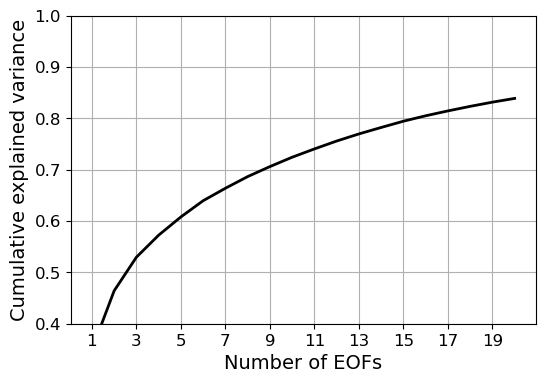

In [4]:
# make a plot of the cumulative explained variance as a function of the number of EOFs
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(np.arange(1, m+1), explained_variance[:m].cumsum(), 'k-', lw=2)
ax.set_xlabel("Number of EOFs", fontsize=14)
ax.set_ylabel("Cumulative explained variance", fontsize=14)
ax.set_xticks(np.arange(1, m+1, 2))
ax.set_yticks(np.arange(0.4, 1.1, 0.1))
ax.set_ylim(0.4, 1)
ax.tick_params(labelsize=12)
ax.grid()
plt.show()
fig.savefig("./report/figures/cumulative_explained_variance.png", dpi=300, bbox_inches='tight')

ValueError: A colormap named "BlWhRe" is already registered.

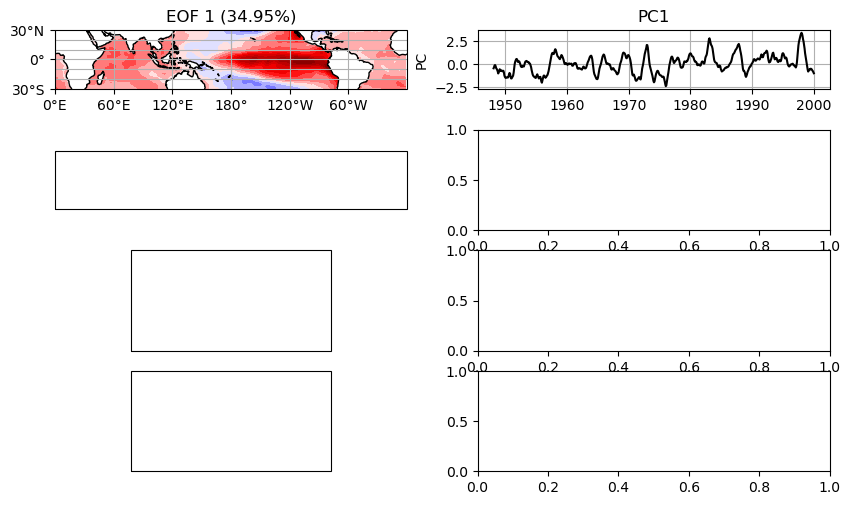

In [5]:
# plot the first 4 EOFs and PCs
# set up the figure, left column for EOFs, right column for PCs
plot_modes = 4
fig = plt.figure(figsize=(10, 6))
# set up the projection
projection = ccrs.PlateCarree(central_longitude=180)
# set up the axes
axes = np.empty((plot_modes, 2), dtype=object)
for i in range(plot_modes):
    axes[i,0] = fig.add_subplot(plot_modes, 2, 2*i+1, projection=projection)
    axes[i,1] = fig.add_subplot(plot_modes, 2, 2*i+2)
# cftime to float
time_fl = [t.year + t.month/12 for t in time]
# plot the first 4 EOFs
for i in range(plot_modes):
    ax = axes[i,0]
    # set extent
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    # plot the EOF
    im = ax.contourf(lon, lat, eofs[i,:,:], levels=np.linspace(-1, 1, 21), 
        cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
    # add coastlines
    ax.coastlines()
    # add gridlines
    ax.gridlines()
    # add title
    ax.set_title(f"EOF {i+1} ({explained_variance[i]*100:.2f}%)")
    # lat and lon ticks
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.set_xticks(np.arange(lon_min, lon_max, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # add colorbar
    if i == plot_modes - 1:
        cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
        fig.colorbar(im, cax=cax, orientation='horizontal')
    aspect_ratio = 1/ax.get_data_ratio()
    # plot the PC
    ax = axes[i,1]
    # set aspect ratio
    ax.plot(time_fl, pcs[:,i], color='k')
    ax.set_title("PC" + str(i+1))
    if i == plot_modes-1:
        ax.set_xlabel("Time")
    ax.set_ylabel("PC")
    # add gridlines
    ax.grid()
    ax.set_aspect(60/360/ax.get_data_ratio())
# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=-0.2)
# show and save the figure
plt.show()
fig.savefig("./report/figures/EOFs_PCs.png", dpi=300, bbox_inches='tight')

In [ ]:
import cftime
# reconstruct the first m EOFs, can also use the solver.reconstructedField()
m = 15
sst_recon = pcs[:, :m] @ (eofs[:m, :, :].reshape(m, -1))
sst_recon = sst_recon.reshape(-1, grid.shape[0], grid.shape[1])
# plot the original SST and the reconstructed SST at 4 time steps
plot_step = 4
time_steps = [cftime.DatetimeGregorian(1949, 1, 1, 0, 0, 0, 0),
                cftime.DatetimeGregorian(1959, 1, 1, 0, 0, 0, 0),
                cftime.DatetimeGregorian(1979, 6, 1, 0, 0, 0, 0),
                cftime.DatetimeGregorian(1999, 12, 1, 0, 0, 0, 0)]
# get time index
time_idx = [np.where(time == t)[0][0] for t in time_steps]
fig, axes = plt.subplots(plot_step, 2, figsize=(10, 6),
                            subplot_kw={'projection': projection})
for i in range(plot_step):
    year, month = time_steps[i].year, time_steps[i].month
    for j in range(2):
        ax = axes[i,j]
        # set extent
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        if j == 0:
            im = ax.contourf(lon, lat, sst_anom[time_idx[i],:,:], levels=np.linspace(-2, 2, 21), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Original SSTA (time={year}-{month:02d})")
        else:
            im = ax.contourf(lon, lat, sst_recon[time_idx[i],:,:], levels=np.linspace(-2, 2, 21), cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Reconstructed SSTA (time={year}-{month:02d})")
        # add coastlines
        ax.coastlines()
        # lat and lon ticks
        ax.set_xticks(np.arange(lon_min, lon_max+1, 60), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
        if i == plot_step - 1:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        else:
            # add ticks but no labels
            ax.set_xticklabels([])
        if j == 0:
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)
        else:
            # add ticks but no labels
            ax.set_yticklabels([])
        # add colorbar
        if i == plot_step - 1:
            cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
            fig.colorbar(im, cax=cax, orientation='horizontal')
plt.subplots_adjust(wspace=0.1, hspace=-0.2)
plt.show()
fig.savefig("./report/figures/reconstruct_ssta.png", dpi=300, bbox_inches='tight')


### 3. Build the linear inverse model

Steps:
* Compute covariance ($\hat{C}$) and lag-covariance matrix ($\hat{C}_{\Delta t}$) in EOF space, where $\Delta t$ is the time lag. $\hat{C} = \frac{1}{N-1} \sum_{t=1}^N P(t)P'(t)$ and $\hat{C}_{\Delta t} = \frac{1}{N-\Delta t - 1} \sum_{t=1}^{N-\Delta t} P(t+\Delta t)P'(t)$, where $'$ stands for the transpose;
* Compute propagator matrix: $\hat{G}$ = $\hat{C}_{\Delta t}\hat{C}^{-1}$ in EOF space;
* Take an initial SSTA state vector $T$ at any $t_0$, regress $T(t_0)$ onto $E_i$ to determine $P_i(t_0)$ and then form $P(t_0)$;
* Make SST forecast in EOF space from $t_0$ to $t_n$: $P(t_n) = G^{\frac{t_n-t_0}{\Delta t}}P(t_0)$;
* Transform the forecast in EOF space, $P(t_n)$, back to the physical space: $T(t_n)=\sum _{i=1}^M P(t_n) E_i$.

In [ ]:
from scipy.linalg import fractional_matrix_power
class LIM(object):
    def __init__(self, sst_t0, eofs, pcs, forecast_months=9, neofs=10, lag=7):
        """
        Parameters
        ----------
        sst_t0 : array-like
            SST anomalies at time t0, (lat, lon)
        eofs : array-like
            EOFs (mode, lat, lon)
        pcs : array-like
            PCs (time, mode)
        forecast_months : int, optional
            Number of months to forecast, by default 9
        neofs : int, optional
            Number of leading EOFs to use, by default 10
        lag : int, optional
            Lag, by default 7
        """
        self.sst_t0 = sst_t0
        self.eofs = eofs
        self.pcs = pcs
        self.forecast_months = forecast_months
        self.neofs = neofs
        self.lag = lag
    
    def _get_propagator_matrix(self):
        """
        Get the propagator matrix
        """
        neofs = self.neofs
        lag = self.lag
        m_pcs = self.pcs[:, :neofs]
        ntime = m_pcs.shape[0]
        # get the covariance matrix
        m_pc_cov = m_pcs.T @ m_pcs / (ntime - 1)
        # get the lag covariance matrix
        m_pc_lag_cov = np.zeros_like(m_pc_cov)
        for i in range(neofs):
            for j in range(neofs):
                m_pc_lag_cov[i,j] = np.sum(m_pcs[lag:, i] * m_pcs[:-lag, j]) / (ntime - lag - 1)
        # get the propagator matrix
        G = m_pc_lag_cov @ np.linalg.inv(m_pc_cov)
        return G
    
    def _get_forecast_pcs(self):
        """
        Get the forecasted PCs
        """
        neofs = self.neofs
        lag = self.lag
        forecast_months = self.forecast_months
        m_eofs = self.eofs[:neofs, :, :]
        G = self._get_propagator_matrix()
        # get the pcs at time t0
        pcs_t0 = []
        for i in range(neofs):
            eof_i = m_eofs[i, :, :]
            # flatten the array
            flattened_eof_i = eof_i.flatten()
            flattened_sst_t0 = self.sst_t0.flatten()
            # remove the nan
            flattened_eof_i = flattened_eof_i[~np.isnan(flattened_sst_t0)]
            flattened_sst_t0 = flattened_sst_t0[~np.isnan(flattened_sst_t0)]
            # regress sst_t0 on eof_i
            coef, _ = np.polyfit(flattened_eof_i, flattened_sst_t0, 1)
            pcs_t0.append(coef)
        pcs_t0 = np.array(pcs_t0)
        # forecast the pcs
        pcs_forecast = np.zeros((forecast_months, neofs))
        for i in range(forecast_months):
            G_power = fractional_matrix_power(G, (i+1)/lag)
            # keep the real part
            G_power = G_power.real
            pcs_forecast[i,:] = G_power @ pcs_t0
        return pcs_forecast

    def forecast(self):
        """
        Forecast SST anomalies
        """
        neofs = self.neofs
        m_eofs = self.eofs[:neofs,:,:]
        forecast_months = self.forecast_months
        pcs_forecast = self._get_forecast_pcs()
        sst_forecast = np.sum(pcs_forecast[:, :, np.newaxis, np.newaxis] * m_eofs, axis=1)
        return sst_forecast
    

### 4. A forecast example

* Take initial SSTA in 2000-01, and forecast SSTA from 2000-02 to 2000-10, and compare them with the observed SSTA.

In [ ]:
sst_t0 = sst_test_anom[0,:,:]
forecast_months = 9
lim = LIM(sst_t0, eofs, pcs, forecast_months=forecast_months)
sst_forecast = lim.forecast()
forecast_times = xr.cftime_range(start=cftime.DatetimeGregorian(2000, 2, 1, 0, 0, 0, 0), 
                            periods=forecast_months, freq='MS')
# plot the forecasted SSTA
plot_forecast_months = 4
plot_forecast_times = forecast_times[::2]
projection = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(plot_forecast_months, 2, figsize=(10, 6),
                            subplot_kw={'projection': projection})
for i in range(plot_forecast_months):
    year, month = plot_forecast_times[i].year, plot_forecast_times[i].month
    for j in range(2):
        ax = axes[i,j]
        # set extent
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        if j == 0:
            im = ax.contourf(lon, lat, sst_test_anom[i*2+1,:,:], levels=np.linspace(-2, 2, 21), 
                            cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Observed SSTA (time={year}-{month:02d})")
        else:
            plot_sst = sst_forecast[i,:,:]
            # check if all data are nan
            if np.all(np.isnan(plot_sst)):
                print(f"All data are nan for time {year}-{month:02d}")
            im = ax.contourf(lon, lat, plot_sst, levels=np.linspace(-2, 2, 21),
                            cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
            ax.set_title(f"Forecasted SSTA (time={year}-{month:02d})")
        # add coastlines
        ax.coastlines()
        # lat and lon ticks
        ax.set_xticks(np.arange(lon_min, lon_max, 60), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
        if i == plot_forecast_months - 1:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        else:
            # add ticks but no labels
            ax.set_xticklabels([])
        if j == 0:
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)
        else:
            # add ticks but no labels
            ax.set_yticklabels([])
        # add colorbar
        if i == plot_forecast_months - 1:
            cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
            fig.colorbar(im, cax=cax, orientation='horizontal')
plt.subplots_adjust(wspace=0.1, hspace=-0.2)
plt.show()
fig.savefig("./report/figures/forecasted_ssta_2000.png", dpi=300, bbox_inches='tight')

### 5. Evaluate the forecast

* Make forecasts from 2000-01 to 2016-12;
* Make correlation maps of the forecast and the observed SSTA at different lead times;

In [ ]:
forecast_months = 10
n_test_time = sst_test_anom.shape[0] - forecast_months
nlat, nlon = sst_test_anom.shape[1:]
# get the forecasted SSTA
sst_forecast = np.zeros((n_test_time, forecast_months, nlat, nlon))
sst_obs = np.zeros_like(sst_forecast)
lim = LIM(sst_t0, eofs, pcs, forecast_months=forecast_months)
for i in range(n_test_time):
    sst_t0 = sst_test_anom[i,:,:]
    lim.sst_t0 = sst_t0
    sst_forecast[i,:,:,:] = lim.forecast()
    sst_obs[i,:,:,:] = sst_test_anom[i+1:i+forecast_months+1,:,:]
# calculate the correlation between the forecasted SSTA and the observed SSTA
corr = np.zeros((forecast_months, nlat, nlon))
for i in range(forecast_months):
    for j in range(nlat):
        for k in range(nlon):
            corr[i,j,k] = np.corrcoef(sst_forecast[:,i,j,k], sst_obs[:,i,j,k])[0,1]


In [ ]:
# plot the correlation
projection = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(forecast_months // 2, 2, figsize=(10, 8),
                            subplot_kw={'projection': projection})
for i in range(forecast_months // 2):
    for j in range(2):
        leading = i * 2 + j
        ax = axes[i,j]
        # set extent
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        im = ax.contourf(lon, lat, corr[leading,:,:], levels=np.linspace(-1, 1, 21), 
                        cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
        ax.set_title(f"Obs. and pred. Correlation (dt={leading+1} month)")
        # add coastlines
        ax.coastlines()
        # lat and lon ticks
        ax.set_xticks(np.arange(lon_min, lon_max, 60), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
        if i == forecast_months // 2 - 1:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        else:
            # add ticks but no labels
            ax.set_xticklabels([])
        if j == 0:
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)
        else:
            # add ticks but no labels
            ax.set_yticklabels([])
        # add colorbar
        if i == forecast_months // 2 - 1:
            cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
            fig.colorbar(im, cax=cax, orientation='horizontal')
plt.subplots_adjust(wspace=0.1, hspace=-0.2)
plt.show()
fig.savefig("./report/figures/corre_at_diff_leading_time", dpi=300, bbox_inches='tight')

In [ ]:
# plot the space average correlation at different leading time
fig, ax = plt.subplots(figsize=(10, 6))
corr_mean = np.nanmean(corr, axis=(1,2))
print("space average correlation at different leading time:")
print(corr_mean)
ax.plot(np.arange(1, forecast_months+1), corr_mean, 'o-')
ax.set_xlabel("Leading time (month)")
ax.set_ylabel("Correlation")
ax.set_title("Space average correlation at different leading time")
ax.grid()
plt.show()
fig.savefig("./report/figures/corre_at_diff_leading_time_mean", dpi=300, bbox_inches='tight')

### 6. Prediction from the latest observation

The latest observation is 2022-11 as of 2022-12-15. Make a prediction from 2022-12 to 2023-8. Dataset is from COBE Sea Surface Temperature (SST) (https://psl.noaa.gov/data/gridded/data.cobe.html)

In [ ]:
# import esmf
import xesmf as xe
# prepare the data for the forecast
cobe_ds = xr.open_dataset("../COBE_sst/sst.mon.mean.nc")
cobe_sst_da = cobe_ds['sst']
# reverse the latitude to make it ascending
cobe_sst_da = cobe_sst_da.reindex(lat=list(reversed(cobe_sst_da.lat)))
# select the region
cobe_sst_da = cobe_sst_da.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
cobe_lat = cobe_sst_da.lat.values
cobe_lon = cobe_sst_da.lon.values
# convert to numpy array
cobe_sst = cobe_sst_da.values
# use the latest 20 years to compute the anomaly
cobe_sst_latest = cobe_sst[-1,:,:]
cobe_sst_anom = cobe_sst_latest - np.mean(cobe_sst[-241::12,:,:], axis=0)
# regrid to the same grid as the NCEP reanalysis
grid_in = {'lon': cobe_lon, 'lat': cobe_lat}
grid_out = {'lon': lon, 'lat': lat}
regridder = xe.Regridder(grid_in, grid_out, 'bilinear')
cobe_sst_anom = regridder(cobe_sst_anom)
cobe_sst_anom[grid == -1] = np.nan
print("shape of the regridded COBE SST anomaly:", cobe_sst_anom.shape)
# make prediction
project_month = 10
lim = LIM(cobe_sst_anom, eofs, pcs, forecast_months=project_month)
cobe_sst_forecast = lim.forecast()
# plot the forecasted SSTA
forecast_times = xr.cftime_range(start=cftime.DatetimeGregorian(2022, 12, 1, 0, 0, 0, 0),
                                periods=project_month, freq='MS')
projection = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(project_month // 2, 2, figsize=(10, 8),
                            subplot_kw={'projection': projection})
for i in range(project_month // 2):
    for j in range(2):
        ax = axes[i,j]
        leading = i * 2 + j
        forecast_t = forecast_times[leading]
        year, month = forecast_t.year, forecast_t.month
        # set extent
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        im = ax.contourf(lon, lat, cobe_sst_forecast[leading,:,:], levels=np.linspace(-2, 2, 21),
                        cmap=cmaps.BlWhRe, transform=ccrs.PlateCarree())
        ax.set_title(f"Forecasted SSTA (time={year}-{month})")
        # add coastlines
        ax.coastlines()
        # lat and lon ticks
        ax.set_xticks(np.arange(lon_min, lon_max, 60), crs=ccrs.PlateCarree())
        ax.set_yticks(np.arange(lat_min, lat_max+1, 30), crs=ccrs.PlateCarree())
        if i == project_month // 2 - 1:
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        else:
            # add ticks but no labels
            ax.set_xticklabels([])
        if j == 0:
            lat_formatter = LatitudeFormatter()
            ax.yaxis.set_major_formatter(lat_formatter)
        else:
            # add ticks but no labels
            ax.set_yticklabels([])
        # add colorbar
        if i == project_month // 2 - 1:
            cax = inset_axes(ax, width="100%", height="10%", loc='lower center', borderpad=-2.6)
            fig.colorbar(im, cax=cax, orientation='horizontal')
plt.subplots_adjust(wspace=0.1, hspace=-0.2)
plt.show()
fig.savefig("./report/figures/forecasted_ssta_newest", dpi=300, bbox_inches='tight')